In [1]:
import os
# get the binary images

sourceFolder = "image-data"
binaryFiles = []
for filename in os.listdir(sourceFolder):
    if 'binarized' in filename: binaryFiles.append(filename)


### the segmentation function
is copied from segmentFunction.py at the moment, but can be played with here to see the immediate results below

In [2]:
import numpy as np
import cv2

def segment_dss_page_PLAY(image):

    bounding_boxes = []
    BB_centers = []
    BB_bottom_lefts = []
    
    im_height, im_width = image.shape

    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    thresholded = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    # open
    morph = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, kernel)
    # close
    morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)
    morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel)

    # dilate 
    morph = cv2.morphologyEx(morph, cv2.MORPH_DILATE, kernel)
    ret, labels = cv2.connectedComponents(morph)
    contours, hierarchy = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for label in range(1, ret):
        component = np.uint8(labels == label) * 255
        contours, _ = cv2.findContours(component, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        # filter out small or invalid bounding boxes
        for j,contour in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            # these are artifacts
            if (w < 20 or h < 30):
                continue

            # sometimes parts of characters are picked out as well, control these to change what gets detected
            contour_area = cv2.contourArea(contour)
            contour_perimeter = cv2.arcLength(contour, True)
            contour_compactness = (4 * np.pi * contour_area) / (contour_perimeter ** 2)
                
            # set appropriate threshold values for area and compactness
            # min_area_threshold = 50
            max_compactness_threshold = 0.4
            if contour_compactness > max_compactness_threshold:
                continue
            # 2px border for legibility
            # use max() and min() to prevent the BB going off the sides of the iamge
            padding = 2
            y1 = max(0, y-padding)
            y2 = min(y+h+padding, im_height)
            x1 = max(0, x-padding)
            x2 = min(x+w+padding, im_width)

            if (y2-y1) > 0 and (x2-x1) > 0:
                BB_centers.append([int(x1+w/2),int(y1+h/2)])
                bounding_boxes.append( [x1,y1,x2,y2] )


    return bounding_boxes, BB_centers

## see the results

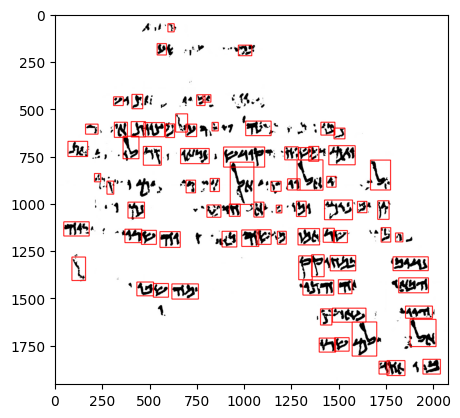

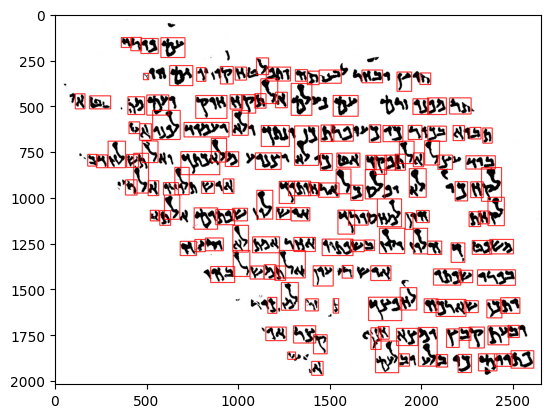

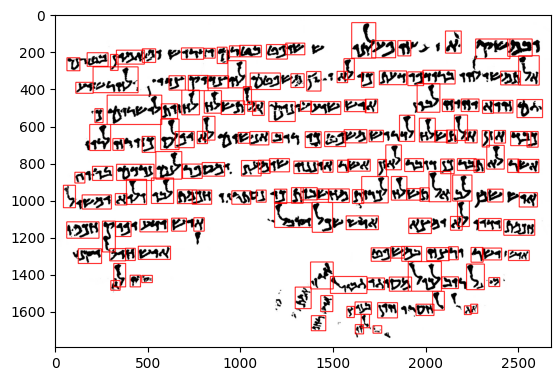

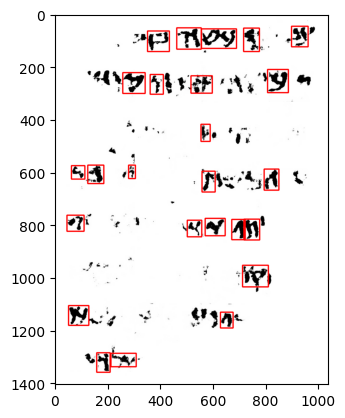

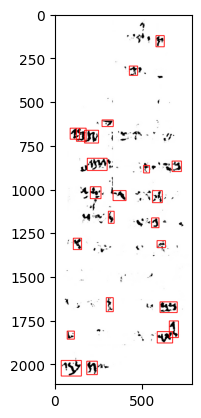

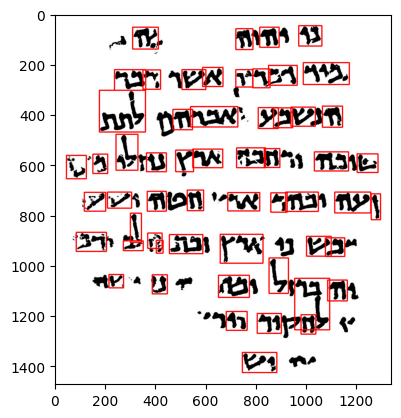

KeyboardInterrupt: 

In [3]:
from data_management.augmentation.commonAug import whitespaceRemover
import cv2
import matplotlib.pyplot as plt

for filename in binaryFiles:
    img_path = os.path.join(sourceFolder, filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #Read the img
    img = whitespaceRemover(img=img, padding=50)

    BBs, BB_centers = segment_dss_page_PLAY(img)

    drawing_img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)

    for (x1,y1,x2,y2) in BBs:
        drawing_img = cv2.rectangle(drawing_img, (x1,y1), (x2,y2), color = (255,0,0), thickness=4)

    #plt.figure(figsize=(12,12))
    plt.imshow(drawing_img)
    plt.show()